In [1]:
import tensorflow as tf
tf.keras.backend.set_floatx('float32')
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint,EarlyStopping
from tensorflow.keras import backend as K

from MD_AE_model import *

import h5py
import numpy as np
import matplotlib.pyplot as plt
from contextlib import redirect_stdout

import time
import os
import datetime

#============================== CCHANGE THESE VALUES ======================
# data
data_file = '../Data/PIV/PIV4_downsampled_by8.h5'
Ntrain = 1800 # snapshots for training
Ntest = 900 # sanpshots for testing

# path
folder = './PIV/Autoencoder/MD_2__2022_02_02__16_51_24/'

## ae configuration
filename = folder + 'Model_param.h5'
file = h5py.File(filename,'r')
lmb = file.get('lmb')[()]#1e-05 #regulariser
drop_rate = file.get('drop_rate')[()]
features_layers = np.array(file.get('features_layers')).tolist()
latent_dim = file.get('latent_dim')[()]
act_fct = file.get('act_fct')[()].decode()
resize_meth = file.get('resize_meth')[()].decode()
filter_window= np.array(file.get('filter_window')).tolist()
batch_norm = file.get('batch_norm')[()]
file.close()

#================================= IMPORT DATA ==========================================================
Nz = 24 # grid size
Ny = 21
Nu = 2
Nt = 2732 # number of snapshots available
D = 196.5 # mm diameter of bluff body
U_inf = 15 # m/s freestream velocity
f_piv = 720.0 # Hz PIV sampling frequency  
dt = 1.0/f_piv 
Nx = [Ny,Nz]

filename = folder + 'results.h5'
file = h5py.File(filename,'r')
u_train = np.array(file.get('u_train'))
y_train = np.array(file.get('y_train'))
u_test = np.array(file.get('u_test'))
y_test = np.array(file.get('y_test'))
# u_avg = np.array(file.get('u_avg'))
latent_train = np.array(file.get('latent_train'))
latent_test = np.array(file.get('latent_test'))
modes_train = np.array(file.get('modes_train'))
modes_test = np.array(file.get('modes_test')) #(modes,snapshots,Nx,Ny,Nu)
file.close()

In [4]:
e = np.abs(y_test-u_test) # (600,21,24,2)
e_mean = np.sum(e)/e.shape[0]
print('mean absolute error per snapshot',e_mean)

mean absolute error per snapshot 849.23875


In [ ]:
print(modes_test.shape)

In [ ]:
md_ae = MD_Autoencoder(Nx=Nx,Nu=Nu,features_layers=features_layers,latent_dim=latent_dim,filter_window=filter_window,act_fct=act_fct,drop_rate=drop_rate,lmb=lmb)

## restore models
filename = folder + 'md_ae_model.h5'
md_ae.load_weights(filename)

encoder = md_ae.encoder
decoders = []
for name in md_ae.name_decoder:
    decoders.append(md_ae.get_layer(name))

In [ ]:
print(y_test.shape)

### Plot results

In [ ]:
time = 0 # which snapshot?
fig, (ax1,ax2) = plt.subplots(ncols=2)
fig1 = ax1.imshow(y_test[time,:,:,0],'jet')
ax1.set_title('v')
fig.colorbar(fig1,ax=ax1)

fig2 = ax2.imshow(y_test[time,:,:,1],'jet')
ax2.set_title('w')
fig.colorbar(fig2,ax=ax2)
plt.suptitle("instantaneous result")
plt.show()

V_test = ((y_test[:,:,:,0]**2)+(y_test[:,:,:,1]**2))**(0.5)
fig = plt.figure()
plt.imshow(V_test[time,:,:],'jet')
plt.colorbar()
plt.title('instantaneous velocity magnitude')
plt.show()

(600, 2)


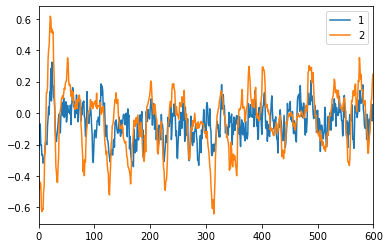

In [5]:
print(latent_test.shape)
plt.figure()
# plt.plot(latent_train[:,0],label='1')
# plt.plot(latent_train[:,1],label='2')
plt.plot(latent_test[:,0],label='1')
plt.plot(latent_test[:,1],label='2')
plt.xlim([0,600])
plt.legend()
plt.show()

In [ ]:
# fft of latent space signal
signal_in = latent_test[:,0]
signal_fft = np.fft.fft(signal_in)
signal_fft_power = np.abs(signal_fft)/signal_in.size
signal_freq = np.fft.fftfreq(signal_in.size)
signal_freq = signal_freq/dt
# print(signal_freq.size/2)
plt.figure()
plt.plot(signal_freq[:int(signal_freq.size/2)],signal_fft_power[:int(signal_freq.size/2)])
plt.ylim(bottom=0)
plt.yticks([0])
plt.xlim(left=0)
loc,label = plt.xticks()
loc = np.r_[0:max(loc):25]
plt.xticks(loc)
plt.show()

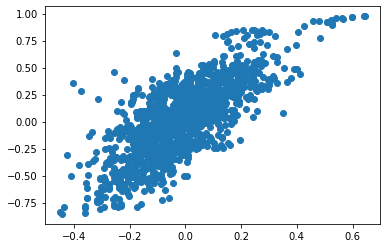

In [6]:
plt.figure()
plt.scatter(latent_train[:,0],latent_train[:,1])
plt.show()

In [ ]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

mode1_1 = ax1.imshow(np.mean(modes_test,axis=1)[0,:,:,0],'jet')
ax1.set_title("Mode 1, v")
ax1.set_xticks([])
ax1.set_yticks([])
fig.colorbar(mode1_1,ax=ax1)

mode1_2 = ax2.imshow(modes_test[0,1,:,:,1],'jet')
ax2.set_title("Mode 1, w")
ax2.set_xticks([])
ax2.set_yticks([])
fig.colorbar(mode1_2,ax=ax2)

mode2_1 = ax3.imshow(np.mean(modes_test,axis=1)[1,:,:,0],'jet')
ax3.set_title("Mode 2, v")
ax3.set_xticks([])
ax3.set_yticks([])
fig.colorbar(mode2_1,ax=ax3)

mode2_2 = ax4.imshow(np.mean(modes_test,axis=1)[1,:,:,1],'jet')
ax4.set_title("Mode 2, w")
ax4.set_xticks([])
ax4.set_yticks([])
fig.colorbar(mode2_2,ax=ax4)
plt.suptitle("u and v autoencoder modes")

In [ ]:
print(modes_test.shape)
modes_test_mean = np.mean(modes_test,axis=1)
print(modes_test_mean.shape)
mode_test = np.transpose(modes_test,[1,0,2,3,4])
print(mode_test.shape)
mode_test = mode_test-modes_test_mean
print(mode_test.shape)
# mode_test = np.transpose(mode_test,[1,0,2,3,4])

In [ ]:
# test_mean = np.mean(u_test,0)
# # # test_mean = np.zeros_like(test_mean)
# print(test_mean.shape)
# mode_test = np.transpose(modes_test,[1,0,2,3,4])
# print(mode_test[:,0,:,:,:].shape)
# mode_test[:,0,:,:,:] = mode_test[:,0,:,:,:]-test_mean
# mode_test[:,1,:,:,:] = mode_test[:,1,:,:,:]-test_mean
# mode_test = np.transpose(mode_test,[1,0,2,3,4])
# print(mode_test.shape)

fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2)

mode1_1 = ax1.imshow(mode_test[time,0,:,:,0],'jet')
ax1.set_title("Mode 1, v")
ax1.set_xticks([])
ax1.set_yticks([])
fig.colorbar(mode1_1,ax=ax1)

mode1_2 = ax2.imshow(mode_test[time,0,:,:,1],'jet')
ax2.set_title("Mode 1, w")
ax2.set_xticks([])
ax2.set_yticks([])
fig.colorbar(mode1_2,ax=ax2)

mode2_1 = ax3.imshow(mode_test[time,1,:,:,0],'jet')
ax3.set_title("Mode 2, v")
ax3.set_xticks([])
ax3.set_yticks([])
fig.colorbar(mode2_1,ax=ax3)

mode2_2 = ax4.imshow(mode_test[time,1,:,:,1],'jet')
ax4.set_title("Mode 2, w")
ax4.set_xticks([])
ax4.set_yticks([])
fig.colorbar(mode2_2,ax=ax4)
plt.suptitle("instantaneous u and v autoencoder modes, remove mean")

In [ ]:
# fix this!!!
# only for when REMOVE_MEAN is True
a = modes_test_mean[0,:,:,0]+mode_test[510,0,:,:,0]
plt.figure()
plt.imshow(modes_test_mean[0,:,:,0],'jet')
plt.show()
plt.figure()
plt.imshow(a,'jet')
plt.show()